# Capstone - Sentiment Analysis of Climate Tweets


A climate project using natural language processing by Max Stocker

You can read a write up of this project on [Medium](https://medium.com/@max.h.stocker/sentiment-analysis-of-climate-tweets-2ea31724ad87)

### Contents <a id= 'top'></a>

1.[Importing](#imports)

2.[Load in data](#loadin)

3.[EDA](#eda)

4.[Test-Train-Validation Splitting](#ttv)

5.[Pre-processing Functions](#ppfunc)

6.[Pre-processing](#pp)

7.[EDA - Wordclouds](#edawc)

8.[Resampling - Under](#resamp)

9.[Resampling - Over](#dsamp)

10.[Vectorization](#vect)

11.[Training Models using Train Set](#model)

12.[Running Models on Test and Validation Sets](#tvset)

13.[Iterating Through Different Train-Test Splits to Measure Average Performance of Models](#ave)

14.[Evaluating Models' Performances](#Eval)

### Importing <a id= 'imports'></a>


In [2]:
import os

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import re
import string

from sklearn.model_selection import train_test_split

import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.cluster import KMeans

from sklearn import metrics
from sklearn.metrics import (confusion_matrix, accuracy_score)
from sklearn.metrics import precision_score, recall_score, f1_score, log_loss

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import itertools
from collections import Counter
from wordcloud import WordCloud

from sklearn.utils import resample
import random

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Max\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Max\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Max\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
lst = [1,2]

for v in range(2):
    lst.insert(-1, lst[v])
    
lst.insert(-1, 3)
lst

[1, 1, 1, 3, 2]

[Return to Contents](#top)

### Load in data <a id='loadin'></a>

From Edward Qian on Kaggle - 
"Twitter Climate Change Sentiment Dataset - 44k tweets pertaining to climate change"

Link: https://www.kaggle.com/edqian/twitter-climate-change-sentiment-dataset

In [5]:
##load data into mainframe
mf = pd.read_csv("twitter_sentiment_data.csv")
mf.head()

sentiment                                            message  \
0         -1  @tiniebeany climate change is an interesting h...   
1          1  RT @NatGeoChannel: Watch #BeforeTheFlood right...   
2          1  Fabulous! Leonardo #DiCaprio's film on #climat...   
3          1  RT @Mick_Fanning: Just watched this amazing do...   
4          2  RT @cnalive: Pranita Biswasi, a Lutheran from ...   

              tweetid  
0  792927353886371840  
1  793124211518832641  
2  793124402388832256  
3  793124635873275904  
4  793125156185137153

In [6]:
##changing the sentiment label to be from 0-3 inc instead of -1-2
##this is for compatibility with KMeans
mf['sentiment'] = mf['sentiment'].apply(lambda x :x+1)

In [7]:
mf.head()

sentiment                                            message  \
0          0  @tiniebeany climate change is an interesting h...   
1          2  RT @NatGeoChannel: Watch #BeforeTheFlood right...   
2          2  Fabulous! Leonardo #DiCaprio's film on #climat...   
3          2  RT @Mick_Fanning: Just watched this amazing do...   
4          3  RT @cnalive: Pranita Biswasi, a Lutheran from ...   

              tweetid  
0  792927353886371840  
1  793124211518832641  
2  793124402388832256  
3  793124635873275904  
4  793125156185137153

In [8]:
print(mf.sentiment.max(), mf.sentiment.min())
##max should == 3, min == 0

3 0


[Return to Contents](#top)

## EDA <a id = 'eda'></a>

Just reading some tweets to see any trends, obvious words, etc

3 (former 2)  ==== (News)    : the tweet links to factual news about climate change

2 (former 1)  ==== (Pro)     : the tweet supports the belief of man-made climate change

1 (former 0)  ==== (Neutral) : the tweet neither supports nor refutes the belief of man-made climate change

0 (former -1)  ==== (Anti)    : the tweet does not believe in man-made climate change

In [9]:
#mf[mf['sentiment'] == 2 ]

shuffled = mf.sample(frac = 1)
#shuffled.head(10)

In [10]:
n = 20

for row in range(0, n):
    print('label = ', shuffled['sentiment'].iloc[row])
    print(shuffled['message'].iloc[row], end = "\n\n ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ \n\n")


label =  2
How do city governments choose their response to climate change? Decisions are not always made formally: many relyâ€¦ https://t.co/0KAMejl0Zo

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

label =  2
Good morning to everyone except those who still donâ€™t believe in climate change

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

label =  3
Demonstrators demand that Roskam address climate change - Chicago Daily Herald https://t.co/Pap018rBC6

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

label =  3
RT @kateauty: Ocean heatwave destroys Tasmania's unique underwater jungle | Climate Home - climate change news https://t.co/yPp3rtIZTu via…

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

label =  2
RT @ClimateCentral: 2017 was the third-hottest year on record, behind 2016 and 2015 â€” a clear indicator of climate change https://t.co/aLpFâ€¦

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

label =  2
And a lot of people ignore the fact that TenNapel is anti-feminism and doesn$q$t believe in climate change. Triple th

Further EDA w/ wordclouds after pre-processing

In [11]:
## class imbalance

sns.countplot(mf.sentiment)

[Return to Contents](#top)

## Train-Test-Validation Splitting <a id = 'ttv'></a>

Train = 75%

Test = 20%

Validation = 5%

In [12]:
###Test-Train Split
X = mf.drop(columns = 'sentiment')
y = mf['sentiment']

##Getting train
X_train, X_test_pre, y_train, y_test_pre = train_test_split(X, y, test_size = 0.25, random_state = 100)

##pulling a validation set too 

X_test, X_val, y_test, y_val = train_test_split(X_test_pre, y_test_pre, test_size = 0.2, random_state = 100)
#X_test = X_test_pre
#y_test = y_test_pre


In [13]:
##function for splitting when we interate the process
def splitter(mainframe, k):
    X = mainframe.drop(columns = 'sentiment')
    y = mainframe['sentiment']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = k)

    return X_train, X_test, y_train, y_test

In [14]:

##checking sets
print('overall data size = ', mf.shape[0], end = '\n\n ~~~~~~~~~~~~~~~ \n\n')

d_sets = {'train' : (X_train, y_train),
         'test' : (X_test,y_test),
         'validation' : (X_val,y_val)}

for k,v in d_sets.items():
    print("Metrics for:", k)
    print('number of rows:', v[0].shape[0])
    print('fraction:', round(v[0].shape[0]/mf.shape[0], 2))
    print('X-y match?', v[0].shape[0]==len(v[1]), end = '\n\n ~~~~~~~~~~~~~~~~~~~~ \n\n')
          

overall data size =  43943

 ~~~~~~~~~~~~~~~ 

Metrics for: train
number of rows: 32957
fraction: 0.75
X-y match? True

 ~~~~~~~~~~~~~~~~~~~~ 

Metrics for: test
number of rows: 8788
fraction: 0.2
X-y match? True

 ~~~~~~~~~~~~~~~~~~~~ 

Metrics for: validation
number of rows: 2198
fraction: 0.05
X-y match? True

 ~~~~~~~~~~~~~~~~~~~~ 



In [15]:
##saving to

for k,v in d_sets.items():
    
    v[0].to_csv(('X_'+k+'.csv'))
    v[1].to_csv(('y_'+k+'.csv'))
    print(k, 'saved')

train saved
test saved
validation saved


[Return to Contents](#top)

## Pre-processing functions <a id = 'ppfunc'></a>

In [16]:
##priming stopwords and lemmatizer
stpwrd = nltk.corpus.stopwords.words('english')
stpwrd.extend(string.punctuation)

stpwrd.extend(['rt', 'co', 'https', 'http', 'amp', 'us'])

commwords = ['climate', 'change', 'global', 'warming','like', 'ðÿ', 'il', 'le', 'gt']


stpwrd.extend(commwords)


lem = WordNetLemmatizer()

In [17]:
def regex_clean(txt, regex):
    """Replace any text matching the regex

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove matches
    regex : string 
        A text string of the regex pattern you want to match

    Returns
    -------
    The same txt string with the matches removes
    """

    return " ".join(re.sub(regex, " ", txt).split())

In [18]:
def prep_text(text):
    """ Cleans up a tweet

    Parameters
    ----------
    text : string
        A tweet that you want to parse and remove matches

    Returns
    -------
    Cleaned up string - tokenized & stemmed!
    """ 
    
    # Pre Token Cleaning
    ###make lower
    text = text.lower()
    ###regex strip -remove all punct
    ####removing mentions
    text = regex_clean(text, r'(?:)@[A-Za-z0-9\-\.\_]+(?:)')
    ##remove links
    text = regex_clean(text, r'(?:(?:http?|https?|ftp):\/\/)\S+')
    
    
    ####no punct
    text = regex_clean(text, r"[^\w\s]" )
    #### no numbers
    text = regex_clean(text, r"\d")
    ##removing single chars
    text = regex_clean(text, r"\b\w\b")
    ##funny thing with tweets having the ã character, stripping it, removing all none a-z chars
    text = regex_clean(text, r"(\S+|\b)[^a-zA-Z\s]\S+")
    text = regex_clean(text, r"[^a-z]+")
    ##removing more none alphabet chars - way of removing none eng words
    #r'(\S+|\b)[^a-zA-Z\s]\S+'
    # tokenise
    text = word_tokenize(text)
    
    # token cleaning
    ###strip stopwords
    text = [word for word in text if word not in stpwrd]
    ###lemmatize those words
    text = [lem.lemmatize(word) for word in text]
    
    return text

In [19]:
def df_cleaner(df, pr = True):
    ##remove tweets with 0 tokens - there's no reasonabe way todo nlp on them - some are images, etc
    if pr:
        print(f'we have {df.shape[0]} tweets')
        print(df.target.value_counts())
        
    no_word_mask = df['token_len'] == 0
    no_words = df[no_word_mask]
    
    word_mask = df['token_len'] != 0
    words = df[word_mask]
    
    ##seems neutral tweets have higher instances of no tokens
    
    if pr:
        print(f'{words.shape[0]} tweets have words, {no_words.shape[0]} have no words')
        print(f'{no_words.shape[0]} tweets dropped')
        print(no_words.target.value_counts())
    return words
    

In [20]:
prep_text("RT @User: This is what 800,000 years of climate change looks like https://t.co/XXXXXXXX")

['year', 'look']

[Return to Contents](#top)

## Pre-processing <a id = 'pp'></a>

In [21]:
##on train
train = X_train.copy()
train['target'] = y_train
#train.head()
## Take a sample - for tweaking preprocessing

#samp = train.sample(n = 15000, random_state = 43)
##full set
samp = train.copy()

In [22]:
##prep tokens
samp['tokens'] = samp['message'].apply(prep_text)
##token length - for upsampling
samp['token_len'] = samp['tokens'].apply(len)
##remove tweets we dont like
samp = df_cleaner(samp)

we have 32957 tweets
2    17214
3     6869
1     5841
0     3033
Name: target, dtype: int64
32822 tweets have words, 135 have no words
135 tweets dropped
1    105
2     20
0      8
3      2
Name: target, dtype: int64


In [23]:
#Token Lengths
print(samp['token_len'].min())
print(samp['token_len'].max())

1
21


In [24]:
##more like "untokener" = this stitches the tokens together into a string - this is so our TF-IDF Vectoriser can handle
# the cleaned tweets - TF-IDF "retokenises" the retoke column
def retoker(tokens):
    s = ' '
 
    s = s.join(tokens)
    return s

In [25]:
#apply untoking
samp['retoke'] = samp['tokens'].apply(retoker)

In [26]:
samp.head()

message             tweetid  \
31243  I was out in this cold snap tonight, and my ch...  957109125804109824   
5192   RT @SenSanders: We have a president-elect who ...  798291253452386306   
43904  RT @SaveLiberty1st: Climate Change is really a...  790586704050556928   
38272    8 Little Things You Can Do About Global Warming  644967613240619011   
20281  RT @RedTRaccoon: As 1,000s march to fight for ...  858387298177634305   

       target                                             tokens  token_len  \
31243       1  [cold, snap, tonight, cheek, pink, look, real,...          9   
5192        2  [president, elect, believe, million, people, g...          8   
43904       0  [really, redistribution, scale, leftist, want,...          7   
38272       2                                    [little, thing]          2   
20281       2  [march, fight, environment, combat, please, wa...         11   

                                                  retoke  
31243   cold snap tonight cheek pink look real cute anti  
5192   president elect believe million people going s...  
43904  really redistribution scale leftist want stifl...  
38272                                       little thing  
20281  march fight environment combat please watch ca...

We have:

Generated tokens

Genned token length - Useful for upsamples

<del>Re</del><b>Un</b>tokenised - for bag of words/tfidf



[Return to Contents](#top)

## Detour - More EDA - WordClouds <a id = 'edawc'></a>

Applying preprocessing to full corpus - see composition of each class with word clouds


In [27]:
train['tokens'] = train['message'].apply(prep_text)

In [28]:
##split into each class

counts = {}

for cl in range(0, 4):
    clss_df = train[train['target'] == cl]
    
    t_c = Counter()
    clss_df['tokens'].apply(t_c.update)
    #print(t_c)
    k = "class_" + str(cl)
    counts[k] = t_c

#clss_df.head()
#counts
#print(counts['class_0'])

In [29]:
##palette function
def twitter_colours(word, font_size, position,orientation,random_state=None, **kwargs):
    return random.choice(['#1DA1F2','#56B9F6','#72C5F8','#80CBF9','#8ED0F9','#96D3FA','#9DD6FA','#ABDCFB', '#C7E8FC','#FFFFFF'])

In [30]:
def cloudword(cl_key):
    wc = WordCloud(width=400, height=400, max_words=100, background_color =
                   "#16202B", color_func = twitter_colours).generate_from_frequencies(counts[cl_key])
    plt.figure(figsize=(24,20))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()


In [31]:
cloudword('class_0')

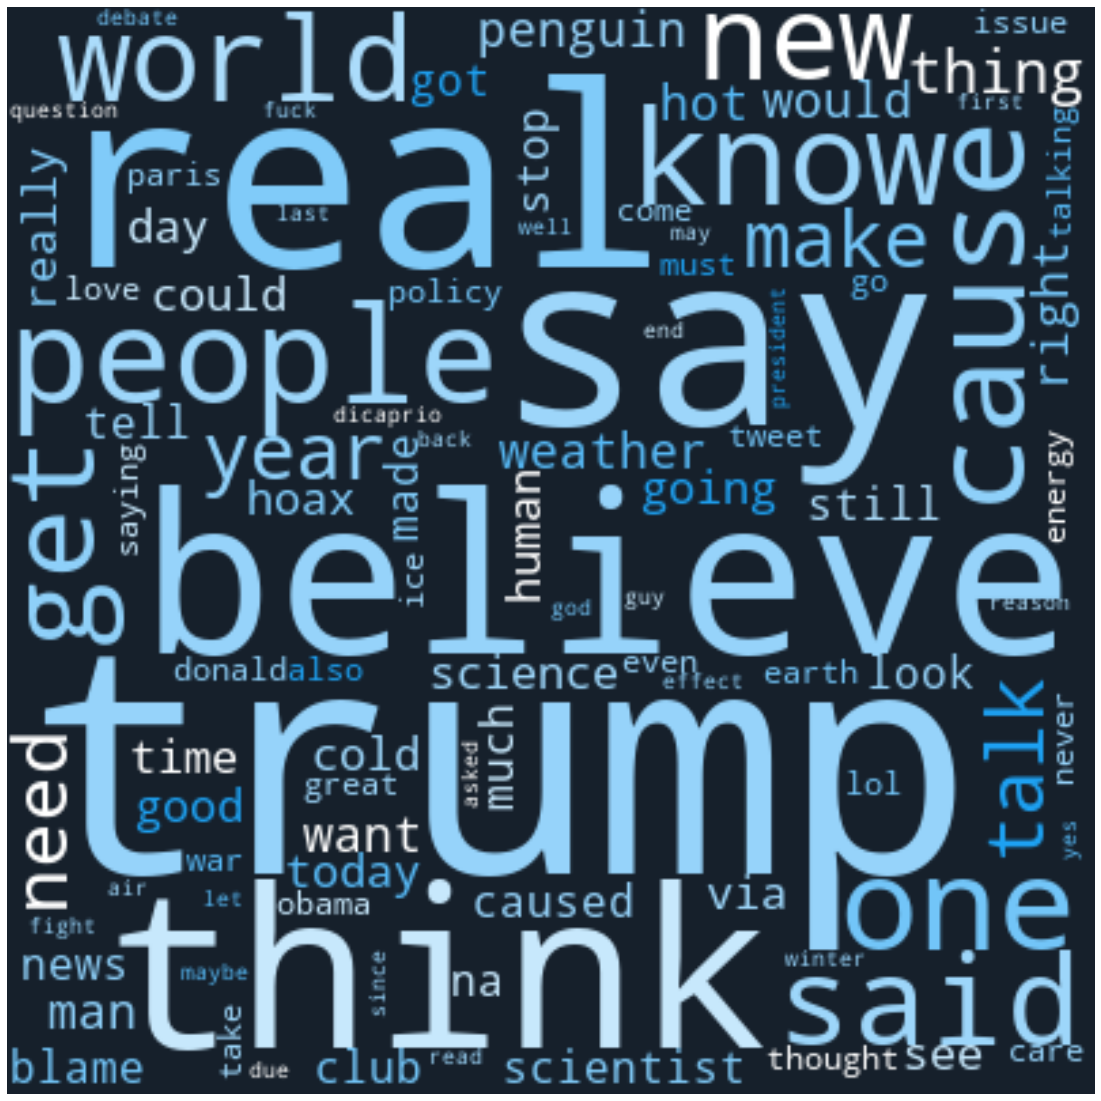

In [32]:
cloudword('class_1')

In [33]:
cloudword('class_2')

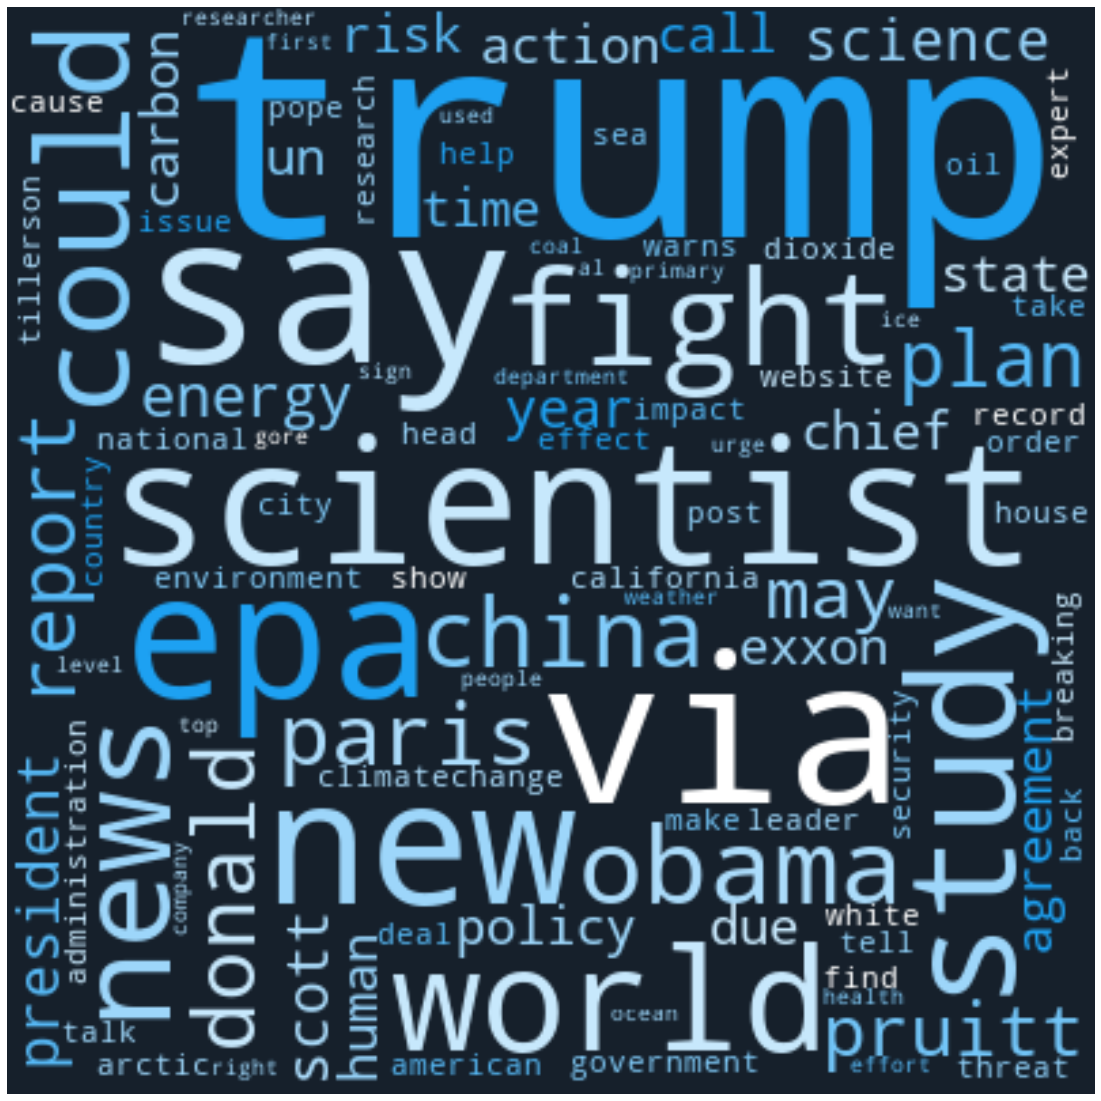

In [34]:
cloudword('class_3')

[Return to Contents](#top)

## Another Detour - Resampling <a id = 'resamp'></a>

While we have pre-processed the data, it is still severely imbalanced - let's fix that

First - a demonstration of class imbalance

In [35]:
counts = pd.DataFrame(samp.groupby('target')['message'].count())
total = counts.message.sum()

counts['percentage'] = round(100* (counts['message']/total))
counts['label'] = counts.index
print(counts)

        message  percentage  label
target                            
0          3025         9.0      0
1          5736        17.0      1
2         17194        52.0      2
3          6867        21.0      3


Text(0.5, 1.0, 'Class Imbalance of Training Data')

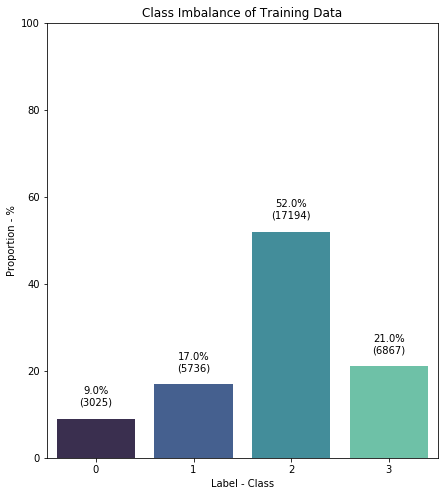

In [36]:
plt.figure(figsize=(7, 8))
g = sns.barplot(x = 'label', y = 'percentage',  data = counts, palette = 'mako')
g.set_ylim(0,100)

c = 0

for p in g.patches:
    txt = str(p.get_height().round()) + '%\n(' + str(counts.message[c]) + ')'
    txt_x = p.get_x() + 0.4
    txt_y = p.get_height() + 3
    g.text(txt_x, txt_y, txt, ha = 'center')
    
    c += 1

plt.ylabel('Proportion - %')
plt.xlabel('Label - Class')
plt.title('Class Imbalance of Training Data')

We'll split the classes into different dataframes for resampling

In [37]:
##split these into classes
resamp = samp.copy()

resamp_pro = resamp[resamp['target'] == 2]
resamp_neut = resamp[resamp['target'] == 1]
resamp_anti = resamp[resamp['target'] == 0]
resamp_news = resamp[resamp['target'] == 3]

frames = [resamp_pro, resamp_neut, resamp_anti, resamp_news]

for frame in frames:
    print(frame.shape[0])

17194
5736
3025
6867


We want all classes to be at 10,000

Downsample - Class 2 (Pro)

Upsample - Classes 0,1,3 (Anti, Neutral, News)

### Downsample

In [38]:
resamp_pro = resample(resamp_pro, replace = False, n_samples = 10000)
# resamp_1

In [39]:
frames = [resamp_pro, resamp_neut, resamp_anti, resamp_news]
for frame in frames:
    print(frame.shape[0])

10000
5736
3025
6867


In [40]:
count_down = pd.concat(frames)

dcounts = pd.DataFrame(count_down.groupby('target')['message'].count())
total = dcounts.message.sum()

dcounts['percentage'] = round(100* (dcounts['message']/total))
dcounts['label'] = dcounts.index
print(dcounts)

        message  percentage  label
target                            
0          3025        12.0      0
1          5736        22.0      1
2         10000        39.0      2
3          6867        27.0      3


Text(0.5, 1.0, 'Class Imbalance of Training Data')

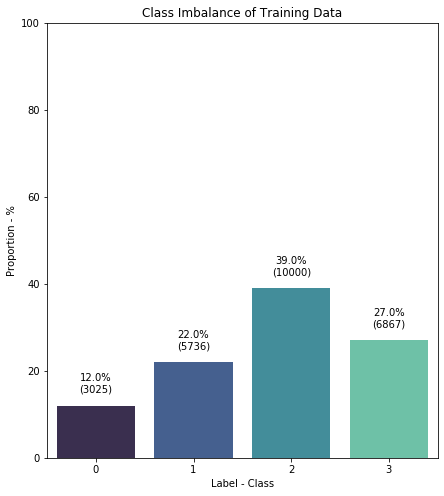

In [41]:
plt.figure(figsize=(7, 8))
g = sns.barplot(x = 'label', y = 'percentage',  data = dcounts, palette = 'mako')
g.set_ylim(0,100)

c = 0

for p in g.patches:
    txt = str(p.get_height().round()) + '%\n(' + str(dcounts.message[c]) + ')'
    txt_x = p.get_x() + 0.4
    txt_y = p.get_height() + 3
    g.text(txt_x, txt_y, txt, ha = 'center')
    
    c += 1

plt.ylabel('Proportion - %')
plt.xlabel('Label - Class')
plt.title('Class Imbalance of Training Data')

[Return to Contents](#top)

### Upsampling Process <a id = 'dsamp'></a>

Get a distribution of token lengths

going to use the empirical data itself as 'distribution' to sample from - this assumes that the empirical distribution is the same as the actual distribution - https://stackoverflow.com/questions/24208536/generating-random-number-for-a-distribution-of-a-real-data



In [42]:
##Distribution function
def get_len_dist(cdf):
    data = list(cdf.token_len)
    return data
    

In [43]:
##Plotting Function
def gen_len_distplot(df, num):
    cnt = Counter()
    
    data = df['token_len']
    
    df[['token_len']].apply(cnt.update)
    plt.figure(num)
    sns.countplot(df.token_len)
    print(cnt)

create token buckets for a range of lengths

In [44]:
def get_token_buckets(df):
    word_ranges = [(1, 6), (6, 11), (11, 16), (16,50)] ##high cap on last one to be more of a 16+ category

    buck_dict = {}

    for limits in word_ranges:
        lim_df = df[(df.token_len >= limits[0]) & (df.token_len < limits[1])]
        s = ''
    
        for retokes in lim_df['retoke']:
            s += retokes
            s += ' '
    
        lim_tokens = word_tokenize(s) 
        
        buck_dict[limits] = lim_tokens
        
    return buck_dict

In [45]:
neut_dict = get_token_buckets(resamp_neut)
#print(neut_dict[(1,6)])
#print(neut_dict[(6,11)])
#print(neut_dict[(11,16)])
#print(neut_dict[(16,50)])

Generate series of new lengths for upsampled data, from len distribution

make a synthetic tweet using a randomly genned length and the correspondinding bucket

In [46]:
def artificial_tweet(to_len, buckets):
    #determine bucket to pull from
    
    for lims in buckets.keys():
        if to_len >= lims[0] and to_len < lims[1]:
            curr_buck = buckets[lims]
    
    ##pull x amount of words from said bucket = 
    new_tokens = []
    
 #   for i in range(to_len):
    return random.choices(curr_buck, k = to_len)

In [47]:
print(artificial_tweet(8, neut_dict))

['see', 'lol', 'remember', 'roy', 'high', 'energy', 'year', 'people']


Apply steps into one function, goes through each class data frame and adds rows until it is new length

In [48]:
def upsample_tweets(raw_df, nu_len, pr = True):
    assert(raw_df.shape[0] < nu_len), "this won't work if the new length is shorter than the original!"
    assert(raw_df.target.min() == raw_df.target.max()), "this only works on data that is labelled as the same - pls filter"
    
    ##confirm df label
    label = raw_df.target.min() ##target, check 1/7
    if pr:
        print(f'proceeding with data for class {label}')
    
    df = raw_df.copy() ##gen copy
    ##since we are making fake tweets - artificial data, we're going to create a column that tracks the authenticity
    df['is_authentic'] = 1
        
    ##first - get lengths of all tweets - to randomly select from - distribution of lengths
    lengths = get_len_dist(df)
    if pr:
        print('lengths got')
    ##then we generate our buckets
    bucket_dict = get_token_buckets(df)
    if pr:
        print('buckets made')
    
    ##now we have our two components - now we can construct a series of artifical tweets and append to the data frame
    #- upsample!
    ###new length 
    to_add = nu_len - df.shape[0]
    if pr:
        print(f'adding {to_add} rows, entering appending loop')
    
    for row in range(to_add):
        
        if row%1000 == 0 and pr:
            print(row)
        
        ##genning new row, start with the token length
        fake_len = random.choice(lengths)
        ##gen fake tokens - our articial tweet function pulls from 
        #the appropriate bucket depending on the length of our tweet
        fake_tokens = artificial_tweet(fake_len, bucket_dict)
        ##tokens, token_len - check 3/7
        ##might as well gen rest of row now, the retoke field
        fake_retoke = retoker(fake_tokens)
        #retoker - check 4/7
        
        ###message, tweetid and is_authentic are hard coded - check 7/7
        app_dict = {'message': 'SYNTHETIC DATA',
                   'tweetid' : np.nan,
                   'target' : label,
                   'tokens' : fake_tokens,
                   'token_len' : fake_len,
                   'retoke' : fake_retoke,
                   'is_authentic' : 0}
        
        df = df.append(app_dict, ignore_index = True)
    if pr:
        print('... done')
    return df

In [49]:
##upsample all the minority classes
upped_dict = {}
for minor, key in [(resamp_anti,'anti'), (resamp_neut, 'neut'), (resamp_news,'news')]:
    upped_dict[key] = upsample_tweets(minor, 10000)
    
    

proceeding with data for class 0
lengths got
buckets made
adding 6975 rows, entering appending loop
0
1000
2000
3000
4000
5000
6000
... done
proceeding with data for class 1
lengths got
buckets made
adding 4264 rows, entering appending loop
0
1000
2000
3000
4000
... done
proceeding with data for class 3
lengths got
buckets made
adding 3133 rows, entering appending loop
0
1000
2000
3000
... done


In [50]:
frames = [resamp_pro, upped_dict['anti'], upped_dict['neut'], upped_dict['news']]
for frame in frames:
    print(frame.shape[0])

10000
10000
10000
10000


Checking how the upsampled data looks - length distributions

In [51]:
gen_len_distplot(resamp_anti, 0)
gen_len_distplot(upped_dict['anti'], 1)

Counter({8: 464, 9: 415, 7: 391, 10: 345, 6: 316, 5: 231, 11: 205, 4: 170, 3: 143, 12: 124, 2: 71, 1: 60, 13: 52, 14: 25, 15: 9, 16: 3, 17: 1})
Counter({8: 1524, 9: 1366, 7: 1286, 10: 1176, 6: 1033, 5: 773, 11: 655, 4: 558, 3: 476, 12: 409, 2: 241, 1: 209, 13: 164, 14: 88, 15: 31, 16: 7, 17: 4})


Counter({9: 644, 8: 615, 7: 572, 5: 559, 4: 528, 6: 525, 10: 511, 3: 413, 2: 345, 11: 335, 1: 243, 12: 221, 13: 99, 14: 66, 15: 26, 16: 18, 17: 9, 18: 5, 21: 1, 19: 1})
Counter({9: 1093, 8: 1054, 7: 997, 5: 969, 10: 923, 6: 907, 4: 906, 3: 709, 2: 610, 11: 587, 1: 460, 12: 406, 13: 177, 14: 103, 15: 44, 16: 30, 17: 15, 18: 8, 21: 1, 19: 1})


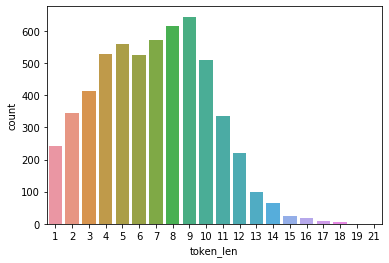

In [52]:
gen_len_distplot(resamp_neut, 0)
gen_len_distplot(upped_dict['neut'], 1)

Counter({7: 1298, 6: 1121, 8: 1073, 5: 844, 9: 815, 10: 563, 4: 416, 11: 287, 3: 165, 12: 155, 13: 67, 2: 40, 14: 16, 1: 4, 16: 2, 15: 1})
Counter({7: 1870, 6: 1639, 8: 1558, 5: 1238, 9: 1206, 10: 839, 4: 604, 11: 398, 3: 243, 12: 225, 13: 103, 2: 50, 14: 20, 1: 4, 16: 2, 15: 1})


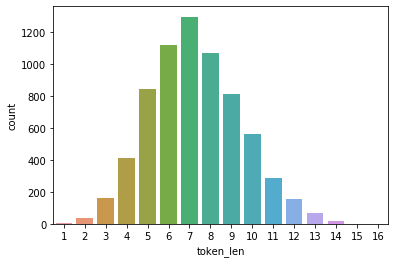

In [53]:
gen_len_distplot(resamp_news, 0)
gen_len_distplot(upped_dict['news'], 1)

Looking pretty similar, checking wordclouds

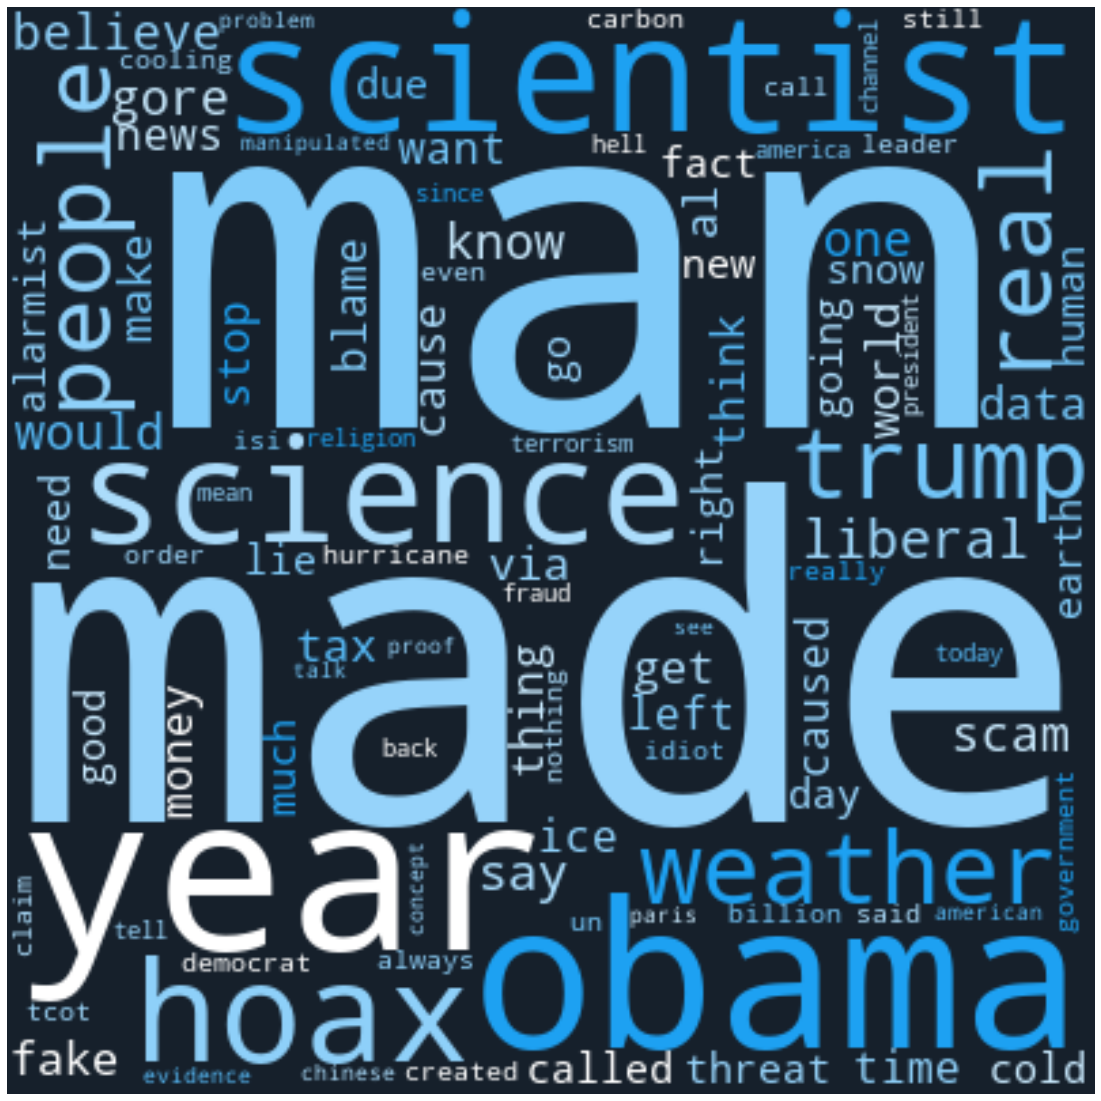

In [54]:
ct_anti = Counter()
    

    
upped_dict['anti']['tokens'].apply(ct_anti.update)
#print(cnt)
wc = WordCloud(width=400, height=400, max_words=100, background_color =
                   "#16202B", color_func = twitter_colours).generate_from_frequencies(ct_anti)
plt.figure(figsize=(24,20))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

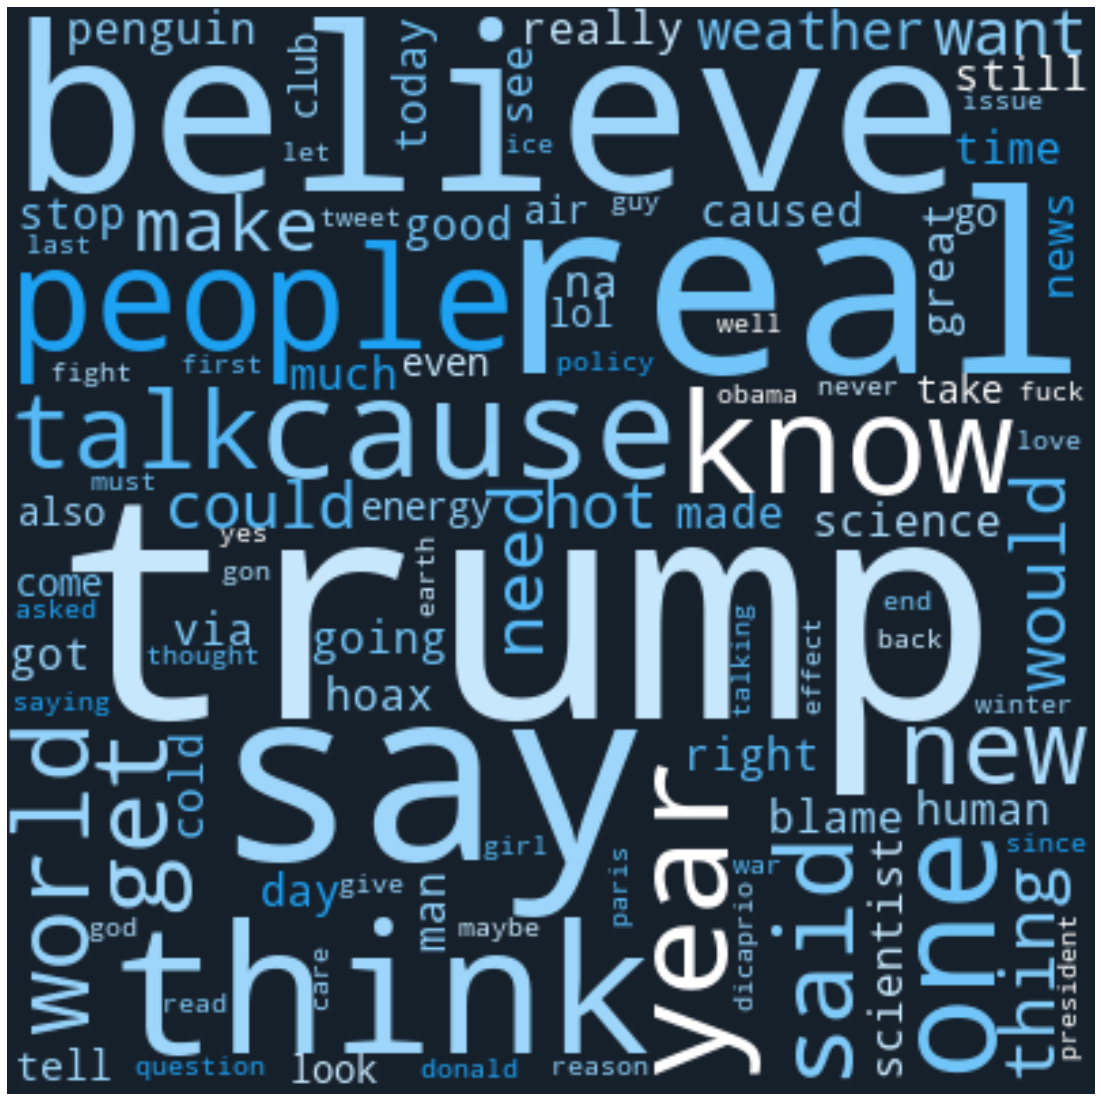

In [55]:
ct_neut = Counter()
    

    
upped_dict['neut']['tokens'].apply(ct_neut.update)
#print(cnt)
wc = WordCloud(width=400, height=400, max_words=100, background_color =
                   "#16202B", color_func = twitter_colours).generate_from_frequencies(ct_neut)
plt.figure(figsize=(24,20))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

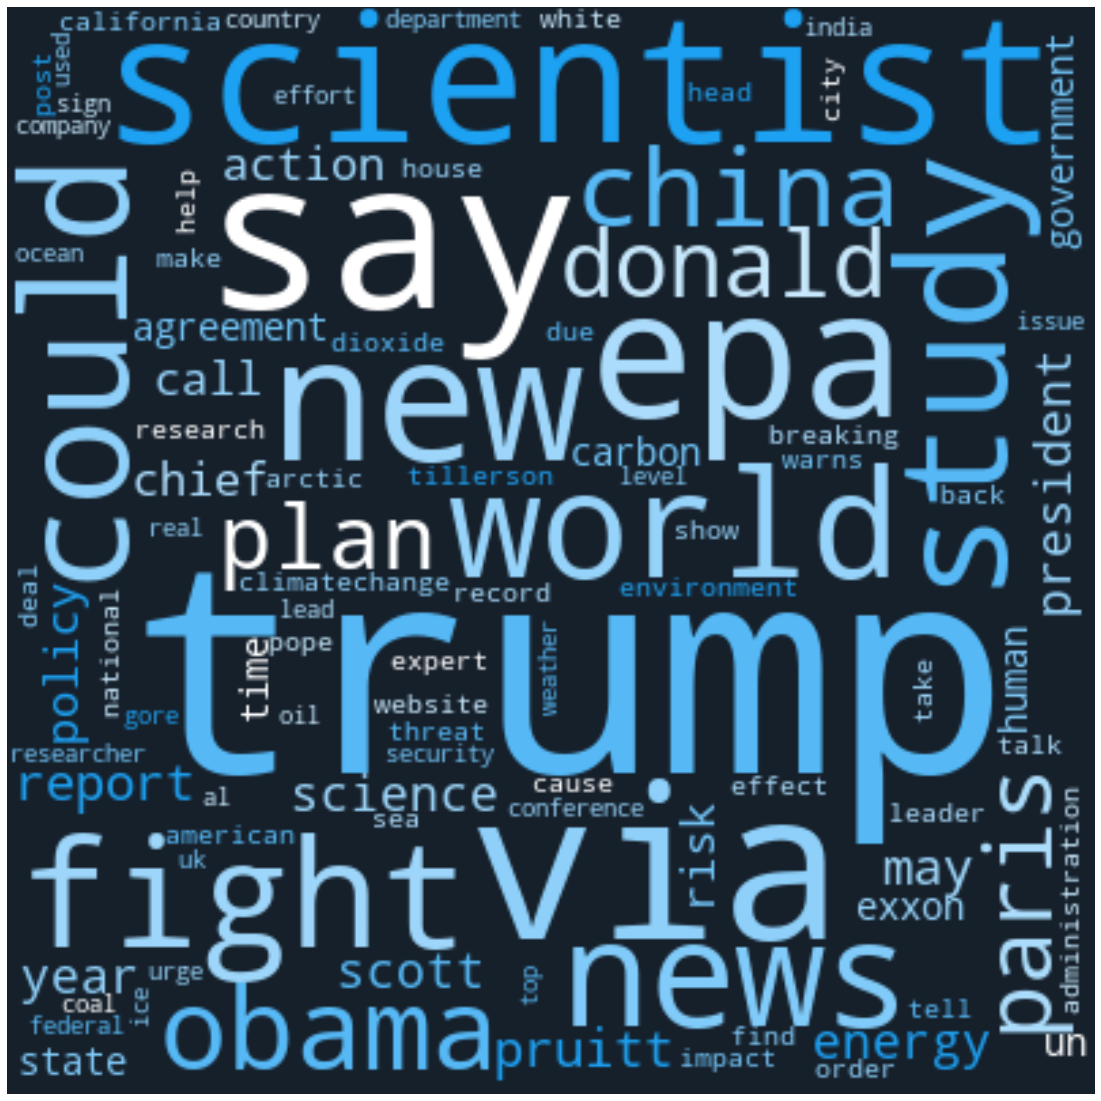

In [56]:
ct_news = Counter()    
upped_dict['news']['tokens'].apply(ct_news.update)
#print(cnt)
wc = WordCloud(width=400, height=400, max_words=100, background_color =
                   "#16202B", color_func = twitter_colours).generate_from_frequencies(ct_news)
plt.figure(figsize=(24,20))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

Look similar to original data, good to work with

In [57]:
##stitch them back together
samp = pd.concat(frames)

In [58]:
rcounts = pd.DataFrame(samp.groupby('target')['message'].count())
total = rcounts.message.sum()

rcounts['percentage'] = round(100* (rcounts['message']/total))
rcounts['label'] = rcounts.index
print(rcounts)

        message  percentage  label
target                            
0         10000        25.0      0
1         10000        25.0      1
2         10000        25.0      2
3         10000        25.0      3


In [59]:
plt.figure(figsize=(7, 8))
g = sns.barplot(x = 'label', y = 'percentage',  data = rcounts, palette = 'mako')
g.set_ylim(0,100)

c = 0

for p in g.patches:
    txt = str(p.get_height().round()) + '%\n(' + str(rcounts.message[c]) + ')'
    txt_x = p.get_x() + 0.4
    txt_y = p.get_height() + 3
    g.text(txt_x, txt_y, txt, ha = 'center')
    
    c += 1

plt.ylabel('Proportion - %')
plt.xlabel('Label - Class')
plt.title('Balanced Training Data')

Text(0.5, 1.0, 'Balanced Training Data')

[Return to Contents](#top)

## Vectorization <a id = 'vect'></a>

In [175]:
tfidf = TfidfVectorizer(analyzer = 'word',
                        max_features = 1500,
                        min_df = 3)
          #              ngram_range = (1,2)) cant use ngrams with upsampled data


In [176]:
tr_feats = tfidf.fit_transform(samp['retoke'])
tr_feats.shape

(40000, 1500)

In [177]:
samp_y = samp['target'].values
len(samp_y)


40000

In [ ]:
samp_X = tr_feats
samp_X.shape[0]

[Return to Contents](#top)

## Modelling - Training Set <a id = 'model'></a>

In [179]:
models = [RandomForestClassifier(max_depth = 15, n_estimators = 3000, random_state = 2),
         LinearSVC(), 
         MultinomialNB(),
         LogisticRegression(random_state = 2, max_iter = 500),
         KMeans(n_clusters = 4, init = 'k-means++') ]

In [180]:
##this method of checking models in parallel inspired by:
###https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
### by Susan Li --- "Multi-Class Text Classification with Scikit-Learn"

def model_performance(models_list, X, y):
    
    model_stats = pd.DataFrame(columns = ['Model','fold','score'])
  
    for model in models_list:
        model_name = model.__class__.__name__
        cross_val = cross_val_score(model, X, y, cv = 10, scoring = 'accuracy')
        for fol, acc in enumerate(cross_val):
            model_stats = model_stats.append({'Model':model_name, 'fold': fol, 'score': acc}, ignore_index = True)

            
        sns.boxplot(x = 'Model', y = 'score', data = model_stats)

        sns.stripplot(x = 'Model', y = 'score', data = model_stats, size = 8, edgecolor = 'gray', linewidth = 2)
    plt.show()

In [181]:
#make preds
def make_preds(mods, dataframe, X, y):
    df = dataframe.copy()
    for m in mods:
        m.fit(X,y)
        m_name = m.__class__.__name__
        lab = 'pred_' + m_name
        df[lab] = m.predict(X)
    return df, mods

In [182]:
def get_model_stats(pred_frame, model_list, X, ret = False, pr = True):
    
    ##if we had a dumb alg to always guessm pro respone - the majority class
    pred_frame['pred_baseline'] = 2
    if pr:
        print('baseline - lazy algorithm that only picks class 2:\n')
    
    base_metrics =metrics.classification_report(pred_frame['target'], pred_frame['pred_baseline']
                                                , output_dict = True , zero_division = 0)
    bp_list = [[0,0,1,0] for i in range(pred_frame.shape[0])]
    baseline_prob = np.array(bp_list)
    bl_ll = log_loss(pred_frame['target'], baseline_prob)
    
    if pr:
        print(metrics.classification_report(pred_frame['target'], pred_frame['pred_baseline'], zero_division = 0))
        print('\n\n log_loss = ', bl_ll)
        print('\n\n #~~~~#~~~~#~~~~#~~~~#~~~~#~~~~# \n\n')      
    ##baseline generated, onto the models 
    
    reports = {'baseline' : base_metrics}
    ll_reports = {'baseline' : bl_ll}
    for model in model_list:
        l = 'pred_' + model.__class__.__name__
        mod_report = metrics.classification_report(pred_frame['target'], pred_frame[l], output_dict = True)
        
        if pr:
            print(l + ':\n')
            print(metrics.classification_report(pred_frame['target'], pred_frame[l]))
        
        reports[model.__class__.__name__] = mod_report
        try:
            m_ll = log_loss(pred_frame['target'], model.predict_proba(X))
            ll_reports[model.__class__.__name__] = m_ll
        except:
            ll_reports[model.__class__.__name__] = np.nan
            
            
        if pr:
            try:   
                print('\n\n log_loss = ', m_ll)
                
            except:
                print('\n\n log_loss = Model does not produce proba')

            print('\n\n #~~~~#~~~~#~~~~#~~~~#~~~~#~~~~# \n\n')
            
            
    
    if ret:
        return reports, ll_reports

In [183]:
samp_preds, fitted_mods = make_preds(models, samp, samp_X, samp_y)


In [184]:
get_model_stats(samp_preds, fitted_mods, samp_X )

baseline - lazy algorithm that only picks class 2:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       0.00      0.00      0.00     10000
           2       0.25      1.00      0.40     10000
           3       0.00      0.00      0.00     10000

    accuracy                           0.25     40000
   macro avg       0.06      0.25      0.10     40000
weighted avg       0.06      0.25      0.10     40000



 log_loss =  25.904082296183002


 #~~~~#~~~~#~~~~#~~~~#~~~~#~~~~# 


pred_RandomForestClassifier:

              precision    recall  f1-score   support

           0       0.74      0.52      0.61     10000
           1       0.40      0.70      0.51     10000
           2       0.66      0.33      0.44     10000
           3       0.60      0.63      0.62     10000

    accuracy                           0.54     40000
   macro avg       0.60      0.54      0.54     40000
weighted avg       0.60      0.

In [185]:
##confusion 

def am_confus(mod_ls, y_actu, y_pred):
    
    matrix = confusion_matrix(y_actu, y_pred)
    plt.figure(figsize = (10,8))
    sns.heatmap(matrix, annot =True, xticklabels = [0,1,2,3], yticklabels = [0,1,2,3], fmt = 'g')
    plt.title(mod_ls)
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

   
    

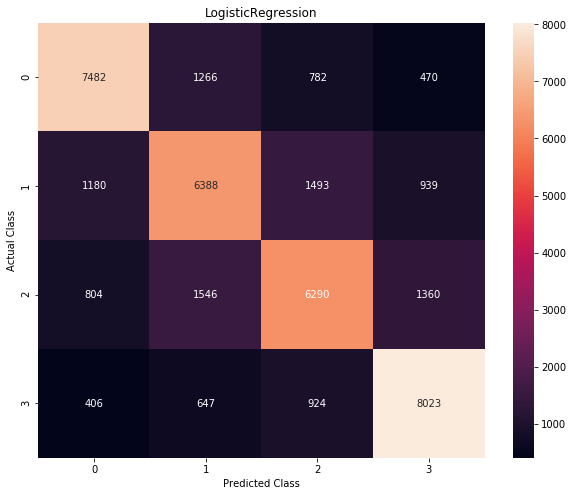

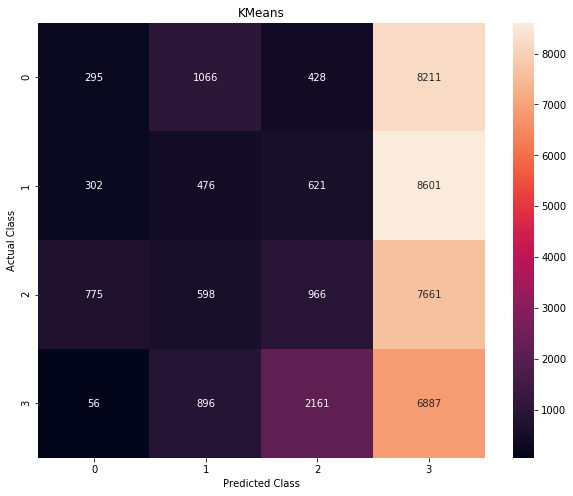

In [186]:
for m in models:
    name = m.__class__.__name__
    lab = 'pred_' + name
    am_confus(name, samp_preds['target'], samp_preds[lab]) 

[Return to Contents](#top)

## Running Models on Test and Validation <a id = 'tvset'></a>
### Testing set

In [187]:
test = X_test.copy()
test['target'] = y_test

In [188]:
test['tokens'] = test['message'].apply(prep_text)

In [189]:
test['retoke'] = test['tokens'].apply(retoker)

In [190]:
te_feats = tfidf.transform(test['retoke'])

In [191]:
te_X = te_feats
te_y = test['target'].values

In [192]:
def make_preds_no_fit(mods, dataframe, X, y):
    df = dataframe.copy()
    for m in mods:
        #m.fit(X,y)
        m_name = m.__class__.__name__
        lab = 'pred_' + m_name
        df[lab] = m.predict(X)
    return df

In [193]:
test_preds = make_preds_no_fit(fitted_mods, test, te_X, te_y)



In [173]:
test_preds

message             tweetid  \
31732  RT @OP_Society: This sea turtle population is ...  960230937593233408   
17612  RT @sofiak2110: Any judge stopping that? Donal...  846646269145743360   
1791   I hunger for copperhead snake as my mind turns...  795239070251237376   
5982   RT @StephenSchlegel: she's thinking about how ...  798818071137792000   
31889  RT @RTUKnews: End of world? British scientists...  962712100543090688   
...                                                  ...                 ...   
9354   RT @rudepundit: Scientists are 'guerrilla arch...  809007912458813441   
14628  On climate change, Scott Pruitt causes an upro...  840158347915583490   
35227  @richie26188 @piersmorgan man made climate cha...  957486221860552704   
13550  This confirms one of two things...\n\n1) clima...  834422091789299717   
23448  Talking about how states are marking out the p...  877735609816588288   

       target                                             tokens  \
31732       2  [sea, turtle, population, almost, female, than...   
17612       2  [judge, stopping, donald, trump, move, decisiv...   
1791        1            [hunger, copperhead, snake, mind, turn]   
5982        2           [thinking, going, die, husband, believe]   
31889       3  [end, world, british, scientist, challenge, un...   
...       ...                                                ...   
9354        3  [scientist, guerrilla, archiving, data, case, ...   
14628       3  [scott, pruitt, cause, uproar, contradicts, ep...   
35227       0  [man, made, big, difference, scientist, grant,...   
13550       2  [confirms, one, two, thing, real, white, peopl...   
23448       2  [talking, state, marking, path, eclipse, next,...   

                                                  retoke  \
31732     sea turtle population almost female thanks via   
17612  judge stopping donald trump move decisively wi...   
1791                   hunger copperhead snake mind turn   
5982                  thinking going die husband believe   
31889  end world british scientist challenge un predi...   
...                                                  ...   
9354   scientist guerrilla archiving data case trump ...   
14628  scott pruitt cause uproar contradicts epa website   
35227       man made big difference scientist grant rely   
13550  confirms one two thing real white people paint...   
23448  talking state marking path eclipse next month ...   

       pred_RandomForestClassifier  pred_LinearSVC  pred_MultinomialNB  \
31732                            3               2                   2   
17612                            3               3                   3   
1791                             1               1                   1   
5982                             2               2                   2   
31889                            3               3                   3   
...                            ...             ...                 ...   
9354                             3               3                   3   
14628                            3               3                   3   
35227                            0               0                   0   
13550                            2               1                   1   
23448                            2               2                   2   

       pred_LogisticRegression  pred_KMeans  
31732                        2            2  
17612                        3            0  
1791                         1            2  
5982                         2            1  
31889                        3            2  
...                        ...          ...  
9354                         3            0  
14628                        3            2  
35227                        0            2  
13550                        2            2  
23448                        2            2  

[8788 rows x 10 columns]

In [194]:
get_model_stats(test_preds, fitted_mods, te_X)

baseline - lazy algorithm that only picks class 2:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       791
           1       0.00      0.00      0.00      1494
           2       0.52      1.00      0.69      4603
           3       0.00      0.00      0.00      1900

    accuracy                           0.52      8788
   macro avg       0.13      0.25      0.17      8788
weighted avg       0.27      0.52      0.36      8788



 log_loss =  16.44797214527779


 #~~~~#~~~~#~~~~#~~~~#~~~~#~~~~# 


pred_RandomForestClassifier:

              precision    recall  f1-score   support

           0       0.42      0.45      0.44       791
           1       0.26      0.69      0.37      1494
           2       0.83      0.29      0.43      4603
           3       0.50      0.61      0.55      1900

    accuracy                           0.44      8788
   macro avg       0.50      0.51      0.45      8788
weighted avg       0.62      0.4

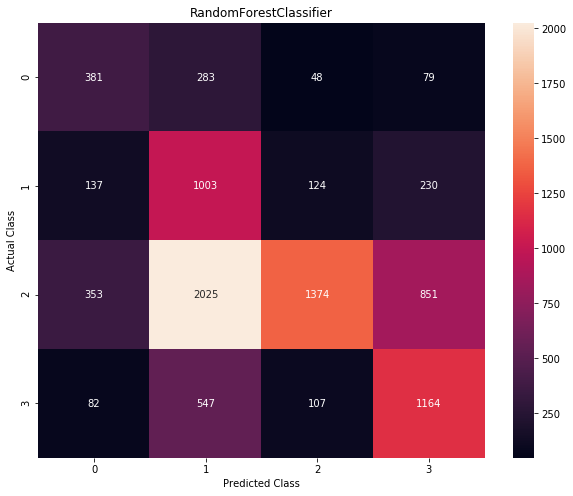

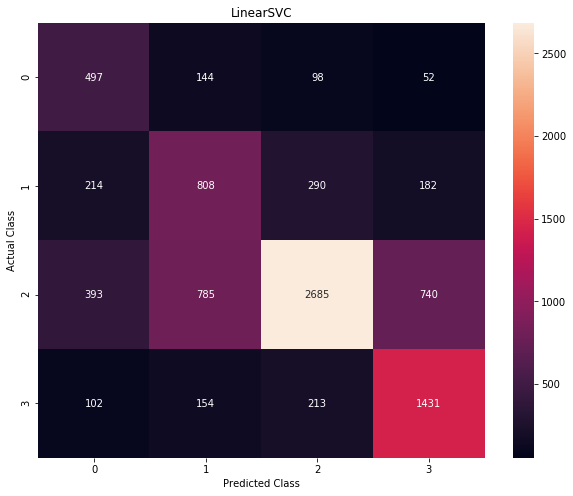

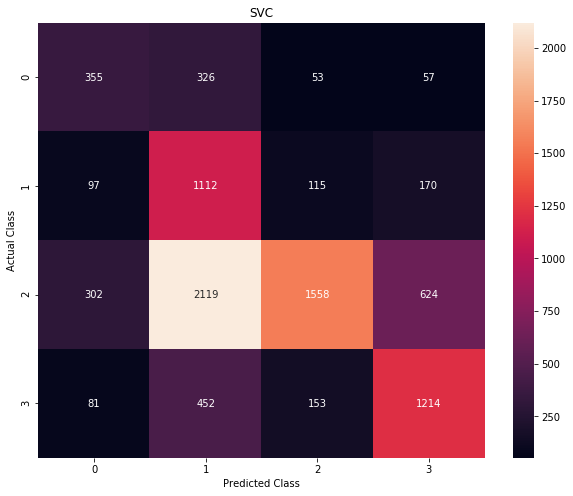

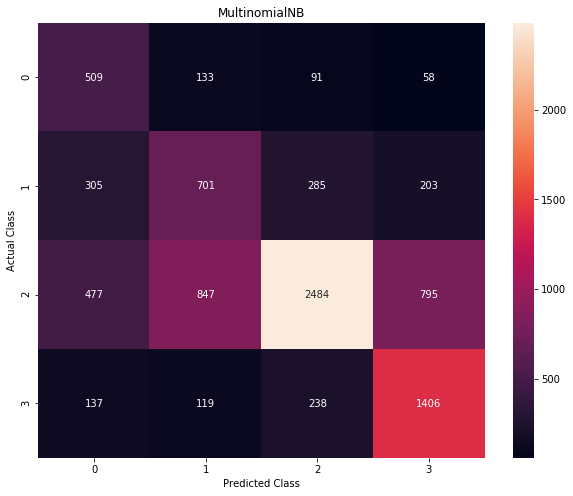

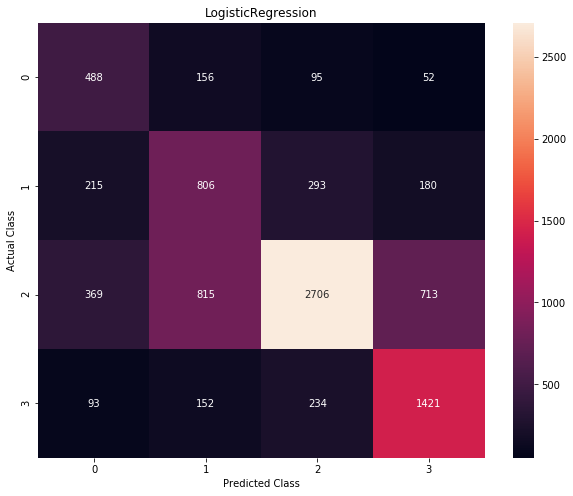

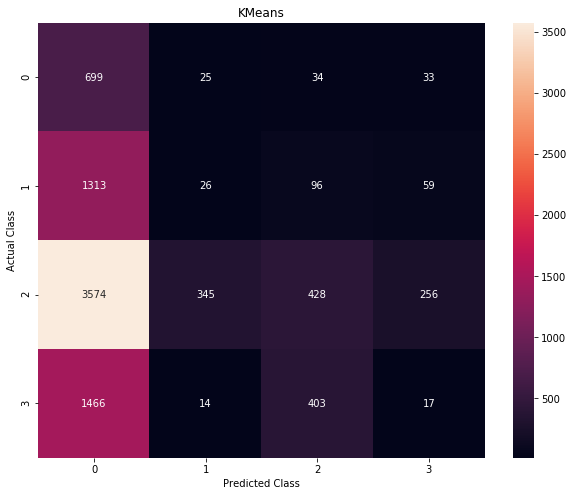

In [117]:
for m in fitted_mods:
    name = m.__class__.__name__
    lab = 'pred_' + name
    am_confus(name, test_preds['target'], test_preds[lab]) 

### Validation Set

In [195]:
val = X_val.copy()
val['target'] = y_val

val['tokens'] = val['message'].apply(prep_text)
val['retoke'] = val['tokens'].apply(retoker)

va_feats = tfidf.transform(val['retoke'])

va_X= va_feats
va_y = val['target'].values

In [196]:
val_preds = make_preds_no_fit(fitted_mods, val, va_X, va_y)



In [197]:
get_model_stats(val_preds, fitted_mods, va_X)

baseline - lazy algorithm that only picks class 2:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       166
           1       0.00      0.00      0.00       380
           2       0.52      1.00      0.69      1145
           3       0.00      0.00      0.00       507

    accuracy                           0.52      2198
   macro avg       0.13      0.25      0.17      2198
weighted avg       0.27      0.52      0.36      2198



 log_loss =  16.54655666234802


 #~~~~#~~~~#~~~~#~~~~#~~~~#~~~~# 


pred_RandomForestClassifier:

              precision    recall  f1-score   support

           0       0.37      0.42      0.39       166
           1       0.25      0.67      0.37       380
           2       0.81      0.26      0.39      1145
           3       0.52      0.65      0.58       507

    accuracy                           0.43      2198
   macro avg       0.49      0.50      0.43      2198
weighted avg       0.61      0.4

[Return to Contents](#top)

## Iterating through different train-test splits to get average performances of each model <a id = 'ave'></a>

In [198]:
import time

In [ ]:
fold_dict_models = {}
fold_dict_preds_train = {}
fold_dict_pred_test = {}

class_stats_train = pd.DataFrame(columns = ['Fold', 'Model', 'Class', 'Precision', 'Recall', 'F1_Score'])
model_stats_train = pd.DataFrame(columns = ['Fold', 'Model', 'Accuracy', 'log_loss', 
                                            'Precision_micro', 'Recall_micro', 'F1_micro',
                                            'Precision_weighted', 'Recall_weighted', 'F1_weighted'])

class_stats_test = pd.DataFrame(columns = ['Fold', 'Model', 'Class', 'Precision', 'Recall', 'F1_Score'])
model_stats_test = pd.DataFrame(columns = ['Fold', 'Model', 'Accuracy', 'log_loss', 
                                            'Precision_micro', 'Recall_micro', 'F1_micro',
                                            'Precision_weighted', 'Recall_weighted', 'F1_weighted'])

In [342]:
# no_nu_fold_dict_models = {}
# no_nu_fold_dict_preds_train = {}
# no_nu_fold_dict_pred_test = {}

# no_nu_class_stats_train = pd.DataFrame(columns = ['Fold', 'Model', 'Class', 'Precision', 'Recall', 'F1_Score'])
# no_nu_model_stats_train = pd.DataFrame(columns = ['Fold', 'Model', 'Accuracy', 'log_loss', 
#                                                 'Precision_micro', 'Recall_micro', 'F1_micro',
#                                                 'Precision_weighted', 'Recall_weighted', 'F1_weighted'])
    
# no_nu_class_stats_test = pd.DataFrame(columns = ['Fold', 'Model', 'Class', 'Precision', 'Recall', 'F1_Score'])
# no_nu_model_stats_test = pd.DataFrame(columns = ['Fold', 'Model', 'Accuracy', 'log_loss', 
#                                             'Precision_micro', 'Recall_micro', 'F1_micro',
#                                             'Precision_weighted', 'Recall_weighted', 'F1_weighted'])

In [279]:
start = time.time()

print('elapsed time = ', round((time.time() - start)/60, 1))



for fold in range(0, 9):
                           
    ##perform split
    print(f'fold = {fold}')
    X_train, X_test, y_train, y_test = splitter(mf, fold)
    
    X_train['target'] = y_train
    print('splitted')
    print('elapsed time = ', round((time.time() - start)/60, 1))
    ##preprocessing
    X_train['tokens'] = X_train['message'].apply(prep_text)
    X_train['token_len'] = X_train['tokens'].apply(len)
    X_train = df_cleaner(X_train, pr = False)
    X_train['retoke'] = X_train['tokens'].apply(retoker)
    print('preprocessed')
    print('elapsed time = ', round((time.time() - start)/60, 1))
    ##resample
    
    X_train_pro = X_train[X_train['target'] == 2]
    X_train_neut = X_train[X_train['target'] == 1]
    X_train_anti = X_train[X_train['target'] == 0]
    X_train_news = X_train[X_train['target'] == 3]
    
    #####down sample pro
    X_train_pro = resample(X_train_pro, replace = False, n_samples = 10000)
    
    ####Up sample
    Xtr_dict = {}
    for minor, key in [(resamp_anti,'anti'), (resamp_neut, 'neut'), (resamp_news,'news')]:
        Xtr_dict[key] = upsample_tweets(minor, 10000, pr = False)
    
    Xframes = [X_train_pro, Xtr_dict['anti'], Xtr_dict['neut'], Xtr_dict['news']]
    
    X_train = pd.concat(Xframes)
    print('resampling done')
    print('elapsed time = ', round((time.time() - start)/60, 1))
    ##bagging
    
    fold_tfidf = TfidfVectorizer(analyzer = 'word',
                        max_features = 1500,
                        min_df = 3)
    
    tr_X = fold_tfidf.fit_transform(X_train['retoke'])
    tr_y = X_train['target'].values
    print('bagged')
    print('elapsed time = ', round((time.time() - start)/60, 1))
    ##modelling
    fold_models = [RandomForestClassifier(max_depth = 15, n_estimators = 3000),
         LinearSVC(),
        # SVC(kernel = 'rbf', gamma = 0.01),
         MultinomialNB(),
         LogisticRegression(max_iter = 500),
         KMeans(n_clusters = 4, init = 'k-means++') ]
    
    train_preds, fold_mods_fitted = make_preds(fold_models, X_train, tr_X, tr_y)               
    print('fitted models, predictions made - train')
    print('elapsed time = ', round((time.time() - start)/60, 1))
    #pulling stats for train
    fold_train_stats, tr_ll_stats = get_model_stats(train_preds, fold_mods_fitted, X_train, ret = True, pr = False)
        
    for trm in fold_train_stats.keys():
        for cls in ['0','1','2','3']:
            pres = fold_train_stats[trm][cls]['precision']
            reca = fold_train_stats[trm][cls]['recall']
            f1 = fold_train_stats[trm][cls]['f1-score']
            
            class_stats_train = class_stats_train.append({'Fold' : fold, 
                                                          'Model' : trm,
                                                          'Class':int(cls), 
                                                          'Precision':pres,
                                                         'Recall': reca,
                                                         'F1_Score' : f1},
                                                        ignore_index = True)
        
        
        
        model_stats_train = model_stats_train.append({'Fold' : fold, 
                                                          'Model' : trm,
                                                          'Accuracy':fold_train_stats[trm]['accuracy'], 
                                                          'log_loss':tr_ll_stats[trm],
                                                         'Precision_micro' : fold_train_stats[trm]['macro avg']['precision'],
                                                      'Recall_micro':fold_train_stats[trm]['macro avg']['recall'],
                                                      'F1_micro':fold_train_stats[trm]['macro avg']['f1-score'],
                                            'Precision_weighted':fold_train_stats[trm]['weighted avg']['precision'],
                                                      'Recall_weighted': fold_train_stats[trm]['weighted avg']['recall'],
                                                      'F1_weighted': fold_train_stats[trm]['weighted avg']['f1-score']},
                                                        ignore_index = True)  
    
    print('train saved, onto test')
    print('elapsed time = ', round((time.time() - start)/60, 1))
    ##do test now
    X_test['target'] = y_test
    
    ##preprocessing
    X_test['tokens'] = X_test['message'].apply(prep_text)
    X_test['token_len'] = X_test['tokens'].apply(len)
    X_test = df_cleaner(X_test, pr = False)
    X_test['retoke'] = X_test['tokens'].apply(retoker)
    ##bagging
    te_X = fold_tfidf.transform(X_test['retoke'])
    te_y = X_test['target'].values
    
    print('test preprocessed and bagged')
    print('elapsed time = ', round((time.time() - start)/60, 1))
    test_preds = make_preds_no_fit(fold_mods_fitted, X_test, te_X, te_y)
    print('test predicted')
    print('elapsed time = ', round((time.time() - start)/60, 1))
    #pulling stats for test
    fold_test_stats, te_ll_stats = get_model_stats(test_preds, fold_mods_fitted, X_test, ret = True, pr = False)
    
    
    ##saving to dictionary
    for trm in fold_train_stats.keys():
        for cls in ['0','1','2','3']:
            pres = fold_test_stats[trm][cls]['precision']
            reca = fold_test_stats[trm][cls]['recall']
            f1 = fold_test_stats[trm][cls]['f1-score']
            
            class_stats_test = class_stats_test.append({'Fold' : fold, 
                                                          'Model' : trm,
                                                          'Class':int(cls), 
                                                          'Precision':pres,
                                                         'Recall': reca,
                                                         'F1_Score' : f1},
                                                        ignore_index = True)
        
        
        
        model_stats_test = model_stats_test.append({'Fold' : fold, 
                                                          'Model' : trm,
                                                          'Accuracy':fold_test_stats[trm]['accuracy'], 
                                                          'log_loss':te_ll_stats[trm],
                                                         'Precision_micro' : fold_test_stats[trm]['macro avg']['precision'],
                                                      'Recall_micro':fold_test_stats[trm]['macro avg']['recall'],
                                                      'F1_micro':fold_test_stats[trm]['macro avg']['f1-score'],
                                            'Precision_weighted':fold_test_stats[trm]['weighted avg']['precision'],
                                                      'Recall_weighted': fold_test_stats[trm]['weighted avg']['recall'],
                                                      'F1_weighted': fold_test_stats[trm]['weighted avg']['f1-score']},
                                                        ignore_index = True)  
    
    print('test stats saved')
    print('elapsed time = ', round((time.time() - start)/60, 1))
    
    ##out of looop - save models and predictions
    fold_dict_models[fold] = fold_mods_fitted
    fold_dict_preds_train[fold] = train_preds
    fold_dict_pred_test[fold] = test_preds
    
    train_preds.to_csv(f'fold_{fold}_train_preds.csv')
    test_preds.to_csv(f'fold_{fold}_test_preds.csv')
    
    class_stats_test.to_csv('test_class_stats.csv')
    model_stats_test.to_csv('test_model_stats.csv')
    
    class_stats_train.to_csv('train_class_stats.csv')
    model_stats_train.to_csv('train_model_stats.csv')
    
    
    print('fold stats saved, next fold')
    print('elapsed time = ', round((time.time() - start)/60, 1))
    
    

elapsed time =  0.0
fold = 0
splitted
elapsed time =  0.0
preprocessed
elapsed time =  0.2
resampling done
elapsed time =  3.5
bagged
elapsed time =  3.5
fitted models, predictions made - train
elapsed time =  5.5


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train saved, onto test
elapsed time =  5.5
test preprocessed and bagged
elapsed time =  5.6
test predicted
elapsed time =  5.7


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


test stats saved
elapsed time =  5.7
fold stats saved, next fold
elapsed time =  5.7
fold = 1
splitted
elapsed time =  5.7
preprocessed
elapsed time =  5.9
resampling done
elapsed time =  8.9
bagged
elapsed time =  8.9
fitted models, predictions made - train
elapsed time =  10.8


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train saved, onto test
elapsed time =  10.8
test preprocessed and bagged
elapsed time =  10.9
test predicted
elapsed time =  11.0


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


test stats saved
elapsed time =  11.0
fold stats saved, next fold
elapsed time =  11.0
fold = 2
splitted
elapsed time =  11.0
preprocessed
elapsed time =  11.2
resampling done
elapsed time =  14.3
bagged
elapsed time =  14.3
fitted models, predictions made - train
elapsed time =  16.2


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train saved, onto test
elapsed time =  16.2
test preprocessed and bagged
elapsed time =  16.3
test predicted
elapsed time =  16.4


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


test stats saved
elapsed time =  16.4
fold stats saved, next fold
elapsed time =  16.4
fold = 3
splitted
elapsed time =  16.4
preprocessed
elapsed time =  16.7
resampling done
elapsed time =  19.9
bagged
elapsed time =  19.9
fitted models, predictions made - train
elapsed time =  21.8


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train saved, onto test
elapsed time =  21.8
test preprocessed and bagged
elapsed time =  21.9
test predicted
elapsed time =  22.0


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


test stats saved
elapsed time =  22.0
fold stats saved, next fold
elapsed time =  22.0
fold = 4
splitted
elapsed time =  22.0
preprocessed
elapsed time =  22.3
resampling done
elapsed time =  25.5
bagged
elapsed time =  25.5
fitted models, predictions made - train
elapsed time =  27.6


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train saved, onto test
elapsed time =  27.6
test preprocessed and bagged
elapsed time =  27.7
test predicted
elapsed time =  27.8


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


test stats saved
elapsed time =  27.8
fold stats saved, next fold
elapsed time =  27.8
fold = 5
splitted
elapsed time =  27.8
preprocessed
elapsed time =  28.0
resampling done
elapsed time =  31.3
bagged
elapsed time =  31.4
fitted models, predictions made - train
elapsed time =  33.5


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train saved, onto test
elapsed time =  33.5
test preprocessed and bagged
elapsed time =  33.6
test predicted
elapsed time =  33.7


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


test stats saved
elapsed time =  33.7
fold stats saved, next fold
elapsed time =  33.7
fold = 6
splitted
elapsed time =  33.7
preprocessed
elapsed time =  34.0
resampling done
elapsed time =  37.3
bagged
elapsed time =  37.3
fitted models, predictions made - train
elapsed time =  39.5


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train saved, onto test
elapsed time =  39.5
test preprocessed and bagged
elapsed time =  39.5
test predicted
elapsed time =  39.7


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


test stats saved
elapsed time =  39.7
fold stats saved, next fold
elapsed time =  39.7
fold = 7
splitted
elapsed time =  39.7
preprocessed
elapsed time =  39.9
resampling done
elapsed time =  43.5
bagged
elapsed time =  43.5
fitted models, predictions made - train
elapsed time =  45.7


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train saved, onto test
elapsed time =  45.7
test preprocessed and bagged
elapsed time =  45.8
test predicted
elapsed time =  45.9


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


test stats saved
elapsed time =  45.9
fold stats saved, next fold
elapsed time =  45.9
fold = 8
splitted
elapsed time =  45.9
preprocessed
elapsed time =  46.2
resampling done
elapsed time =  49.7
bagged
elapsed time =  49.7
fitted models, predictions made - train
elapsed time =  51.9


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train saved, onto test
elapsed time =  51.9
test preprocessed and bagged
elapsed time =  52.0
test predicted
elapsed time =  52.1


C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


test stats saved
elapsed time =  52.1
fold stats saved, next fold
elapsed time =  52.1


In [219]:
class_stats_train

Fold                   Model Class  Precision    Recall  F1_Score
0     0                baseline     0   0.000000  0.000000  0.000000
1     0                baseline     1   0.000000  0.000000  0.000000
2     0                baseline     2   0.525111  1.000000  0.688620
3     0                baseline     3   0.000000  0.000000  0.000000
4     0  RandomForestClassifier     0   1.000000  0.012504  0.024700
5     0  RandomForestClassifier     1   1.000000  0.011474  0.022688
6     0  RandomForestClassifier     2   0.537683  0.999478  0.699214
7     0  RandomForestClassifier     3   0.957478  0.093835  0.170920
8     0               LinearSVC     0   0.709335  0.428861  0.534541
9     0               LinearSVC     1   0.625200  0.414298  0.498354
10    0               LinearSVC     2   0.732186  0.869479  0.794949
11    0               LinearSVC     3   0.703921  0.688748  0.696252
12    0                     SVC     0   0.000000  0.000000  0.000000
13    0                     SVC     1   1.000000  0.004413  0.008787
14    0                     SVC     2   0.531843  0.998375  0.693991
15    0                     SVC     3   0.835214  0.053169  0.099973
16    0           MultinomialNB     0   0.813616  0.246367  0.378210
17    0           MultinomialNB     1   0.626757  0.196823  0.299570
18    0           MultinomialNB     2   0.643230  0.923278  0.758221
19    0           MultinomialNB     3   0.722900  0.561575  0.632107
20    0      LogisticRegression     0   0.725478  0.397432  0.513537
21    0      LogisticRegression     1   0.620569  0.407944  0.492278
22    0      LogisticRegression     2   0.720360  0.878011  0.791411
23    0      LogisticRegression     3   0.717025  0.666331  0.690749
24    0                  KMeans     0   0.003273  0.000676  0.001120
25    0                  KMeans     1   0.186564  0.899029  0.309004
26    0                  KMeans     2   0.452788  0.093784  0.155385
27    0                  KMeans     3   0.050936  0.009772  0.016397

In [ ]:
make_preds_no_fit(fold_mods_fitted, X_test, te_X, te_y)

In [223]:
te_X

<10958x1500 sparse matrix of type '<class 'numpy.float64'>'
	with 57330 stored elements in Compressed Sparse Row format>

[Return to Contents](#top)

### Evaluating Models <a id = 'Eval'></a>

In [199]:
class_stats_test = pd.read_csv('test_class_stats.csv', index_col = 'Unnamed: 0')
model_stats_test = pd.read_csv('test_model_stats.csv', index_col = 'Unnamed: 0')
    
class_stats_train = pd.read_csv('train_class_stats.csv', index_col = 'Unnamed: 0')
model_stats_train = pd.read_csv('train_model_stats.csv', index_col = 'Unnamed: 0')

In [200]:
model_stats_train

Fold                   Model  Accuracy   log_loss  Precision_micro  \
0      0                baseline  0.250000  25.904082         0.062500   
1      0  RandomForestClassifier  0.548025        NaN         0.606635   
2      0               LinearSVC  0.707825        NaN         0.706002   
3      0           MultinomialNB  0.671400        NaN         0.667336   
4      0      LogisticRegression  0.707275        NaN         0.705993   
..   ...                     ...       ...        ...              ...   
61     8  RandomForestClassifier  0.541300        NaN         0.608750   
62     8               LinearSVC  0.703425        NaN         0.701540   
63     8           MultinomialNB  0.670150        NaN         0.665871   
64     8      LogisticRegression  0.702400        NaN         0.701042   
65     8                  KMeans  0.258600        NaN         0.253668   

    Recall_micro  F1_micro  Precision_weighted  Recall_weighted  F1_weighted  
0       0.250000  0.100000            0.062500         0.250000     0.100000  
1       0.548025  0.546176            0.606635         0.548025     0.546176  
2       0.707825  0.706226            0.706002         0.707825     0.706226  
3       0.671400  0.667399            0.667336         0.671400     0.667399  
4       0.707275  0.706249            0.705993         0.707275     0.706249  
..           ...       ...                 ...              ...          ...  
61      0.541300  0.537502            0.608750         0.541300     0.537502  
62      0.703425  0.701690            0.701540         0.703425     0.701690  
63      0.670150  0.665971            0.665871         0.670150     0.665971  
64      0.702400  0.701337            0.701042         0.702400     0.701337  
65      0.258600  0.158582            0.253668         0.258600     0.158582  

[66 rows x 10 columns]

In [201]:
model_stats_test

Fold                   Model  Accuracy  log_loss  Precision_micro  \
0      0                baseline  0.520807  16.55075         0.130202   
1      0  RandomForestClassifier  0.448896       NaN         0.508641   
2      0               LinearSVC  0.623654       NaN         0.578963   
3      0           MultinomialNB  0.577751       NaN         0.537157   
4      0      LogisticRegression  0.626757       NaN         0.580577   
..   ...                     ...       ...       ...              ...   
61     8  RandomForestClassifier  0.443369       NaN         0.515204   
62     8               LinearSVC  0.626416       NaN         0.580486   
63     8           MultinomialNB  0.583760       NaN         0.541526   
64     8      LogisticRegression  0.631531       NaN         0.583561   
65     8                  KMeans  0.140482       NaN         0.269530   

    Recall_micro  F1_micro  Precision_weighted  Recall_weighted  F1_weighted  
0       0.250000  0.171227            0.271240         0.520807     0.356705  
1       0.526451  0.456388            0.631982         0.448896     0.449397  
2       0.652472  0.596833            0.680595         0.623654     0.631775  
3       0.611375  0.549432            0.648279         0.577751     0.587133  
4       0.650633  0.598790            0.679798         0.626757     0.635070  
..           ...       ...                 ...              ...          ...  
61      0.524446  0.452449            0.640957         0.443369     0.442225  
62      0.649701  0.597671            0.681778         0.626416     0.635266  
63      0.611778  0.554371            0.649719         0.583760     0.593739  
64      0.648801  0.601464            0.680588         0.631531     0.640440  
65      0.260050  0.106519            0.459809         0.140482     0.110941  

[66 rows x 10 columns]

In [202]:
model_stats_test.columns[2:]

Index(['Accuracy', 'log_loss', 'Precision_micro', 'Recall_micro', 'F1_micro',
       'Precision_weighted', 'Recall_weighted', 'F1_weighted'],
      dtype='object')

In [219]:
from matplotlib.lines import Line2D

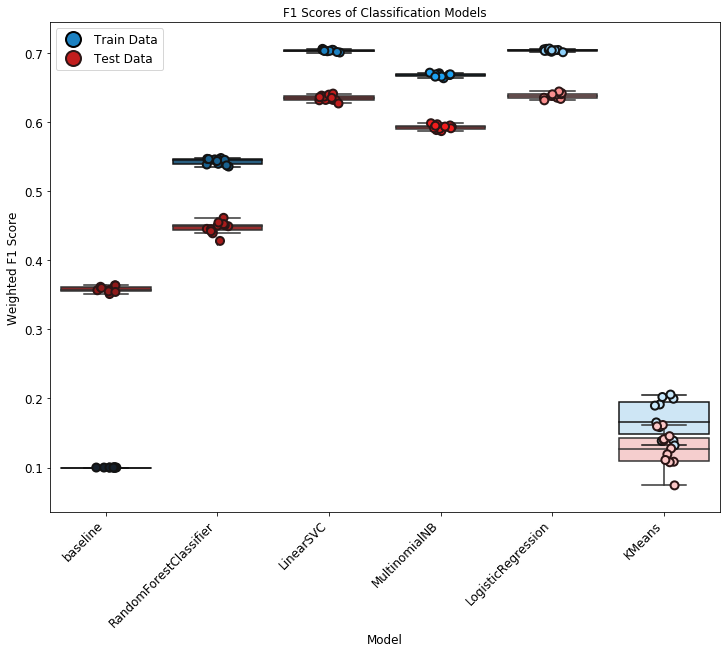

In [232]:


#for s in model_stats_test.columns[2:]:
score = 'F1_weighted'
plt.figure(score ,figsize= (12, 9))

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


sns.boxplot(x = 'Model', y = score, data = model_stats_train,
            palette = ['#16202B','#1A618F','#1C81C1','#1DA1F2','#8ED0F9', '#C7E8FC'])
sns.boxplot(x = 'Model', y = score, data = model_stats_test,
            palette = ['#8F1A1A','#A91C1C','#C21D1D','#F21D1D','#FA8E8E', '#FCC7C7'])

sns.stripplot(x = 'Model', y = score, data = model_stats_train, size = 8, edgecolor = 'gray', linewidth = 2,
              palette = ['#16202B','#1A618F','#1C81C1','#1DA1F2','#8ED0F9', '#C7E8FC'], label = "Train")
sns.stripplot(x = 'Model', y = score, data = model_stats_test, size = 8, edgecolor = '#2b1616', linewidth = 2,
              palette = ['#8F1A1A','#A91C1C','#C21D1D','#F21D1D','#FA8E8E', '#FCC7C7'], label = "Test")

plt.ylabel('Weighted F1 Score')
plt.xticks(rotation=45, ha='right')
plt.title('F1 Scores of Classification Models')

plt.legend([Line2D([0],[0], color = 'b', marker = 'o', markerfacecolor = '#1C81C1',
                   markersize = 15, ls = '', markeredgecolor = 'black', markeredgewidth = 2),
           Line2D([0],[0], color = 'r', marker = 'o', markerfacecolor = '#C21D1D',
                  markersize = 15, ls = '', markeredgecolor = '#2b1616', markeredgewidth = 2)], 
           ['Train Data', 'Test Data'], loc = 'upper left')



plt.show()

In [205]:
model_stats_train.groupby('Model')['F1_weighted'].mean()

Model
KMeans                    0.171238
LinearSVC                 0.703739
LogisticRegression        0.704218
MultinomialNB             0.668258
RandomForestClassifier    0.543200
baseline                  0.100000
Name: F1_weighted, dtype: float64

In [206]:
model_stats_test.groupby('Model')['F1_weighted'].mean()

Model
KMeans                    0.126826
LinearSVC                 0.634908
LogisticRegression        0.637967
MultinomialNB             0.592879
RandomForestClassifier    0.447265
baseline                  0.357898
Name: F1_weighted, dtype: float64

In [288]:
class_stats_train['Model'].unique()

array(['baseline', 'RandomForestClassifier', 'LinearSVC', 'MultinomialNB',
       'LogisticRegression', 'KMeans'], dtype=object)

LinearSVC


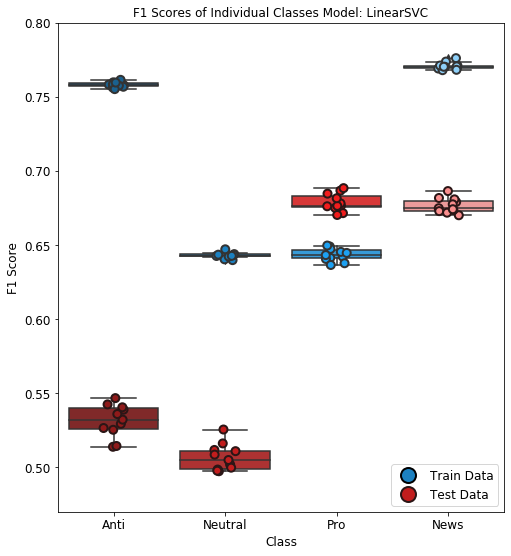

LogisticRegression


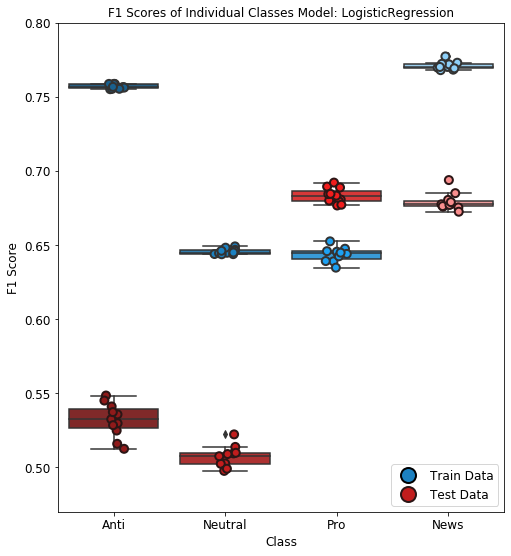

In [234]:
ms = ['LinearSVC',
       'LogisticRegression']


for s in ['F1_Score']:
    for this_m in ms:
        class_stats_train_filt = class_stats_train[class_stats_train['Model'] == this_m]
        class_stats_test_filt = class_stats_test[class_stats_test['Model'] == this_m]
        print(this_m) 
        score = s

        plt.figure(score ,figsize= (8, 9))
        plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
        plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
        plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        #plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
        #plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
        
        sns.boxplot(x = 'Class', y = score, data = class_stats_train_filt, palette = ['#1A618F','#1C81C1','#1DA1F2','#8ED0F9', '#C7E8FC'])
        sns.boxplot(x = 'Class', y = score, data = class_stats_test_filt, palette = ['#8F1A1A','#C21D1D','#F21D1D','#FA8E8E', '#FCC7C7'])

        sns.stripplot(x = 'Class', y = score, data = class_stats_train_filt, size = 8, edgecolor = 'gray', linewidth = 2, palette = ['#1A618F','#1C81C1','#1DA1F2','#8ED0F9', '#C7E8FC'])
        sns.stripplot(x = 'Class', y = score, data = class_stats_test_filt, size = 8, edgecolor = '#2B1616', linewidth = 2, palette = ['#8F1A1A','#C21D1D','#F21D1D','#FA8E8E', '#FCC7C7'])
        
        plt.ylim(0.47,0.8)
        plt.ylabel('F1 Score')
        plt.xticks(ticks = [0,1,2,3],labels =['Anti', 'Neutral', 'Pro', 'News'])
        plt.title(f'F1 Scores of Individual Classes Model: {this_m}')
        
        
        plt.legend([Line2D([0],[0], color = 'b', marker = 'o', markerfacecolor = '#1C81C1',
                   markersize = 15, ls = '', markeredgecolor = 'black', markeredgewidth = 2),
           Line2D([0],[0], color = 'r', marker = 'o', markerfacecolor = '#C21D1D',
                  markersize = 15, ls = '', markeredgecolor = '#2b1616', markeredgewidth = 2)], 
           ['Train Data', 'Test Data'], loc = 'lower right')
        
        plt.show()

[Return to Contents](#top)